In [13]:
data_location = 'sqlite:///../../../data/data.db'

In [14]:
data_location

'sqlite:///../../../data/data.db'

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [16]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [17]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [18]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [19]:
ohlc

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC
...,...,...,...,...,...,...,...,...,...
11622,2021-12-14 20:00:00,178.99,181.27,178.72,180.28,628.699000,1.130815e+05,COMP,ETH
11623,2021-12-14 21:00:00,180.15,183.76,179.96,183.43,2453.455000,4.447119e+05,COMP,ETH
11624,2021-12-14 22:00:00,183.31,186.74,182.60,185.24,2086.017000,3.865710e+05,COMP,ETH
11625,2021-12-14 23:00:00,185.22,186.09,183.88,185.08,416.028000,7.698720e+04,COMP,ETH


In [20]:
tokens = ohlc.token.unique()

In [38]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change(),
            ret_o=df.open.pct_change(),
            ret_v=df.volume.pct_change(),
        )[['ts', 'vol', 'ret','ret_o','ret_v']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret','ret_o','ret_v'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [39]:
X.shape

(1057, 44)

In [40]:
X

,vol_BTC,ret_BTC,ret_o_BTC,ret_v_BTC,vol_ETH,ret_ETH,ret_o_ETH,ret_v_ETH,vol_USDT,ret_USDT,...,ret_o_CRV,ret_v_CRV,vol_AAVE,ret_AAVE,ret_o_AAVE,ret_v_AAVE,vol_COMP,ret_COMP,ret_o_COMP,ret_v_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2021-11-01 01:00:00,0.000000,0.004357,-0.001224,0.296557,0.000000,0.006874,-0.001483,0.858585,0.000000,0.0000,...,-0.000452,1.325772,0.000000,0.008043,-0.000277,4.182691,0.000000,-0.002281,0.015831,-0.410075
2021-11-01 02:00:00,0.000000,-0.004508,0.004316,-0.054832,0.000000,-0.005322,0.006904,-0.405786,0.000000,-0.0002,...,-0.002237,0.493193,0.000000,-0.009171,0.008881,-0.695572,0.000000,-0.006020,-0.002280,1.027650
2021-11-01 03:00:00,0.000000,-0.012132,-0.004508,2.372884,0.000000,-0.013126,-0.005368,1.759066,0.000000,0.0001,...,-0.031660,0.893575,0.000000,-0.013301,-0.008894,2.232113,0.000000,-0.022273,-0.005583,0.304494
2021-11-01 04:00:00,0.000000,-0.010186,-0.012113,-0.413717,0.000000,-0.010679,-0.013091,-0.369918,0.000000,0.0000,...,-0.010571,-0.645935,0.000000,-0.016452,-0.013465,-0.305942,0.000000,-0.024002,-0.022077,-0.338418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 20:00:00,0.136358,0.004810,0.000581,0.091387,0.158369,0.005961,-0.002917,-0.181660,0.002463,0.0001,...,-0.003040,0.046972,0.207758,0.009387,-0.006591,0.012027,0.284268,0.006813,-0.013177,-0.289177
2021-12-14 21:00:00,0.142237,0.019797,0.004666,1.085632,0.170096,0.016737,0.005710,1.182159,0.002652,0.0000,...,0.003049,0.091288,0.222014,0.022490,0.011304,0.978585,0.281497,0.017473,0.006481,2.902432
2021-12-14 22:00:00,0.151148,0.010414,0.019835,0.103677,0.172081,0.004623,0.017168,-0.040696,0.002684,0.0000,...,0.021277,0.287834,0.220598,0.006242,0.022417,-0.428094,0.275083,0.009868,0.017541,-0.149763


In [41]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [42]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [44]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [45]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    

In [51]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1,3, 5, 10, 20, 22],
    'model__alpha': [0.1, 0.5,0.6,0.7,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 0.6, 0.7, 1.0],
                         'pca__n_components': [1, 3, 5, 10, 20, 22]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [52]:
best_model = search.best_estimator_

In [53]:
evaluate_model(best_model, X, y)

-0.008562092264797542

<module 'matplotlib.pyplot' from '/Users/qinyuan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

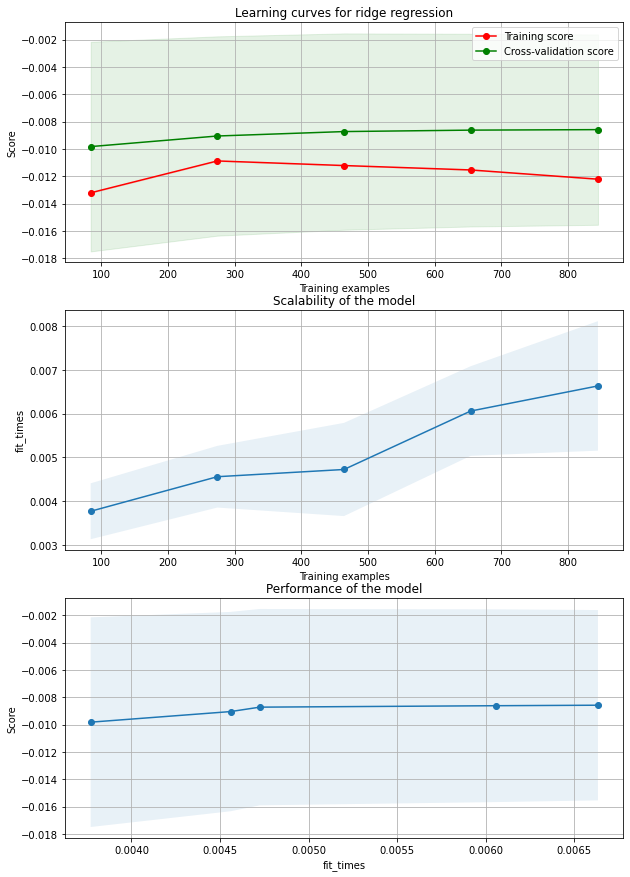

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)
